In [1]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Modelling steps 3 and 4.
## Needs a network, clustered zones with volumes and level of service attributes.

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
car = stepmodel.read_json(model_path + 'de_road_los')

In [4]:
# Create LoS table
sm.car_los = car.car_los
sm.los = sm.pt_los.append(sm.car_los)
sm.los.reset_index(drop=True, inplace=True)
print(len(sm.los))
sm.los.sample(3)

1544439


,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,path,price,route_type,route_types,time,waiting_time
663053,536,0.668924,DE223,420.0,14400,680629,"[rail_long_309, bus_397126, bus_173063, rail_l...",5,DEA41,None,70.089920,rail_long_distance,"[rail_long_distance, bus]",18956,3600.0
232639,1883,0.000000,DE27E,0.0,17220,715189,"[rail_short_84073, rail_short_84074, rail_long...",5,DE929,None,134.685268,rail_long_distance,"[rail_long_distance, rail_short_distance]",22703,3600.0
1240658,441,0.871169,DEF04,1422.0,9360,743421,"[bus_2261670, bus_2261671, rail_short_123802, ...",5,DEB25,None,204.413445,air,"[bus, rail_short_distance, air]",16923,5700.0


In [5]:
# Clean LoS table
sm.los = sm.los.loc[sm.los['time']>0]

In [6]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

In [7]:
# Scale time to hours
sm.los['time'] = sm.los['time'] / 3600

In [8]:
# Create a column for non-linear time
#sm.los['time2'] = np.power(sm.los['time'], 2)

### Prepare the logit model

In [9]:
# Link route types are going to be the PT nest's modes
route_types = ['rail_long_distance', 'rail_short_distance',
               'coach', 'bus', 'air','car', 'walk', 'root']

In [10]:
# Trip purposes from transport demand input data
segments = ['Fz1', 'Fz2', 'Fz3', 'Fz4', 'Fz6']

In [11]:
# Performance attributes for mode choice
perf_attrs = ['time', 'price', 'accessibility']

In [33]:
# Load estimation results
excel = pd.ExcelFile(input_path + 'estimation_results.xlsx')
params_est = []
for segment in range(2, len(segments)+2): # First two sheets are all purposes
    df = excel.parse(segment)
    params_est.append(df.set_index(df.columns[0]))
df = excel.parse(1) # NL for all purposes
params_root = df.set_index(df.columns[0])

In [34]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
nests = pd.DataFrame({'root': pd.Series({rt: 'pt' for rt in route_types})})
nests.loc['pt', 'root'] = 'root'
nests.loc[['car', 'walk', 'air'], 'root'] = 'root'
nests.loc[['root'], 'root'] = np.nan
for seg in segments:
    nests[seg] = nests['root']
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,root,Fz1,Fz2,Fz3,Fz4,Fz6
route_type,,,,,,
rail_long_distance,pt,pt,pt,pt,pt,pt
rail_short_distance,pt,pt,pt,pt,pt,pt
coach,pt,pt,pt,pt,pt,pt
bus,pt,pt,pt,pt,pt,pt
air,root,root,root,root,root,root
car,root,root,root,root,root,root
walk,root,root,root,root,root,root
root,NaN,NaN,NaN,NaN,NaN,NaN
pt,root,root,root,root,root,root


In [35]:
# phi/theta values for each mode and nest come from calibration data
segs = segments + ['root']
sm.logit_scales = pd.DataFrame({seg: [] for seg in segs})
sm.logit_scales.loc['root'] = [1 for seg in segs]
sm.logit_scales.loc['pt'] = [1 / params_est[i].loc['mu_pt', 'Value']
                             for i in range(len(segments))
                            ] + [1 / params_root.loc['mu_pt', 'Value']]
sm.logit_scales.loc['rail_short_distance'] = [1 for seg in segs]
sm.logit_scales.loc['rail_long_distance'] = [1 for seg in segs]
sm.logit_scales.loc['coach'] = [1 for seg in segs]
sm.logit_scales.loc['bus'] = [1 for seg in segs]
sm.logit_scales.loc['air'] = [1 for seg in segs]
sm.logit_scales.loc['car'] = [1 for seg in segs]
sm.logit_scales.loc['walk'] = [1 for seg in segs]
sm.logit_scales

,Fz1,Fz2,Fz3,Fz4,Fz6,root
root,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
pt,0.892155,0.658995,0.521676,0.393167,0.558313,0.558313
rail_short_distance,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
rail_long_distance,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
coach,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
bus,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
air,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
car,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
walk,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
# Initial values are the alternative specific constants from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments + ['root']})
for t, asc in [('rail_short_distance', 'asc_rail'),
               ('rail_long_distance', 'asc_rail'),
               ('coach', 'asc_coach'), ('bus', 'asc_bus'),
               ('air', 'asc_air'), ('car', 0),
               ('walk', 'asc_non_motor'),('root', 0)]:
    sm.mode_utility.loc[t] = [params_est[i].loc[asc, 'Value']
                              if isinstance(asc, str) else asc
                              for i in range(len(segments))
                             ] + [params_root.loc[asc, 'Value']
                                  if isinstance(asc, str) else asc]
sm.mode_utility

,Fz1,Fz2,Fz3,Fz4,Fz6,root
rail_short_distance,0.240016,-0.779462,-0.345747,-0.258669,-0.458487,-0.458487
rail_long_distance,0.240016,-0.779462,-0.345747,-0.258669,-0.458487,-0.458487
coach,-3.240164,-2.215358,-2.458203,-0.855339,-1.120000,-1.120000
bus,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
air,-8.045044,-5.653291,-3.394782,-1.729514,-3.329158,-3.329158
car,2.005429,-1.318506,2.530423,2.696343,2.459396,2.459396
walk,-2.133486,-3.656894,-1.227661,-0.943090,-0.565105,-0.565105
root,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
# Beta parameters from calibration data
# IMPORTANT: conversion
sm.utility_values = pd.DataFrame({seg: [] for seg in segments})
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
sm.utility_values.loc['time'] = [params_est[i].loc['b_t', 'Value']
                                 for i in range(len(segments))] # in EUR/h
#sm.utility_values.loc['time2'] = [params_est[i].loc['b_t2', 'Value']
#                                 for i in range(len(segments))]
sm.utility_values.loc['price'] = [params_est[i].loc['b_c', 'Value']
                                  for i in range(len(segments))]
sm.utility_values.loc['accessibility'] = [params_est[i].loc['b_ac', 'Value']
                                          for i in range(len(segments))]
sm.utility_values['root'] = [1, params_root.loc['b_t', 'Value'],
#                             params_root.loc['b_t2', 'Value'],
                             params_root.loc['b_c', 'Value'],
                             params_root.loc['b_ac', 'Value']]
sm.utility_values

,Fz1,Fz2,Fz3,Fz4,Fz6,root
mode_utility,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
time,-1.637644,-1.701632,-1.042323,-0.733170,-0.734379,-0.734379
price,-0.121231,-0.038075,-0.025669,0.008491,0.000755,0.000755
accessibility,0.866006,0.222267,0.780125,0.761575,0.610780,0.610780


In [38]:
# Show the performance attributes
t = sm.los.sample(n=10).sort_values('length').set_index(
    ['origin', 'destination', 'route_type'])[perf_attrs+['length']]
t

,,,time,price,accessibility,length
origin,destination,route_type,,,,
DE274,DE114,rail_short_distance,1.752778,48.257782,0.535575,96130
DE256,DE714,rail_short_distance,4.347500,64.389167,0.344361,344796
DEA13,DEB3I,rail_long_distance,3.482222,99.290008,0.161924,400251
DE218,DEB3H,rail_short_distance,4.993333,139.000000,0.010574,452058
DE259,DEA5B,rail_long_distance,4.063889,114.261011,0.000000,509274
DE237,DE40I,coach,7.842778,51.075859,0.000000,549027
DE94F,DE141,coach,9.780833,71.841670,0.396807,708234
DE222,DEA45,rail_long_distance,5.580278,83.433886,0.691905,724360
DED21,DEB1A,rail_long_distance,6.803889,119.703017,0.000000,735696


In [39]:
# Example utility decomposition
for a in perf_attrs:
    t[a] = t[a] * sm.utility_values.loc[a,'root']
t

,,,time,price,accessibility,length
origin,destination,route_type,,,,
DE274,DE114,rail_short_distance,-1.287204,0.036438,0.327119,96130
DE256,DE714,rail_short_distance,-3.192714,0.048618,0.210329,344796
DEA13,DEB3I,rail_long_distance,-2.557272,0.074971,0.098900,400251
DE218,DEB3H,rail_short_distance,-3.667001,0.104955,0.006458,452058
DE259,DEA5B,rail_long_distance,-2.984436,0.086275,0.000000,509274
DE237,DE40I,coach,-5.759574,0.038566,0.000000,549027
DE94F,DE141,coach,-7.182842,0.054246,0.242362,708234
DE222,DEA45,rail_long_distance,-4.098041,0.062999,0.422602,724360
DED21,DEB1A,rail_long_distance,-4.996636,0.090384,0.000000,735696


## Mode Choice

In [40]:
# Build the utility column in sm.los for each segment
sm.segments = segments
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
sm.analysis_mode_utility(how='max', segment=None)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


In [41]:
# Create empty OD matrices for od_probabilities and od_utilities
#sm.initialize_logit()

In [42]:
# Run the logit model
sm.step_logit()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


In [43]:
print(sm.probabilities.shape)
print(sm.utilities.shape)

(774210, 12)
(774210, 12)


In [44]:
sm.probabilities.sample(n=5)

route_type,origin,destination,segment,root,walk,car,air,pt,bus,coach,rail_short_distance,rail_long_distance
436727,DE219,DE254,Fz3,1,0.0,0.947342,0.000000e+00,0.052658,0.0,0.011206,0.003657,0.037796
748560,DE22C,DEB13,Fz6,1,0.0,0.761684,2.152894e-01,0.023026,0.0,0.000000,0.015609,0.007418
41379,DEA17,DE261,Fz1,1,0.0,0.984673,6.503163e-09,0.015327,0.0,0.000079,0.000000,0.015248
421374,DE21A,DE231,Fz3,1,0.0,0.959121,0.000000e+00,0.040879,0.0,0.000000,0.040762,0.000116
421658,DE21A,DEF08,Fz3,1,0.0,0.025736,9.655396e-01,0.008725,0.0,0.000000,0.000000,0.008725


In [45]:
sm.utilities.sample(n=5)

route_type,origin,destination,segment,root,walk,car,air,pt,bus,coach,rail_short_distance,rail_long_distance
350545,DE932,DEG0E,Fz3,-4.756886,-inf,-4.779956,-9.490702,-9.024670,-inf,-10.808396,-10.752362,-9.062073
421715,DE21C,DE132,Fz3,-1.946955,-inf,-1.994116,-inf,-5.024636,-inf,-5.029774,-7.464371,-8.999534
97426,DE256,DEF01,Fz1,-18.077807,-inf,-18.184177,-25.299890,-20.378620,-inf,-inf,-33.032411,-20.378621
204249,DE213,DEA59,Fz2,-10.472476,-inf,-14.369979,-10.534305,-13.699785,-inf,-19.703818,-inf,-13.699857
429330,DEB35,DE71D,Fz3,2.100930,-inf,2.100930,-inf,-inf,-inf,-inf,-inf,-inf


### Save model

In [46]:
sm.to_json(model_path + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [00:14<00:00,  2.65it/s]


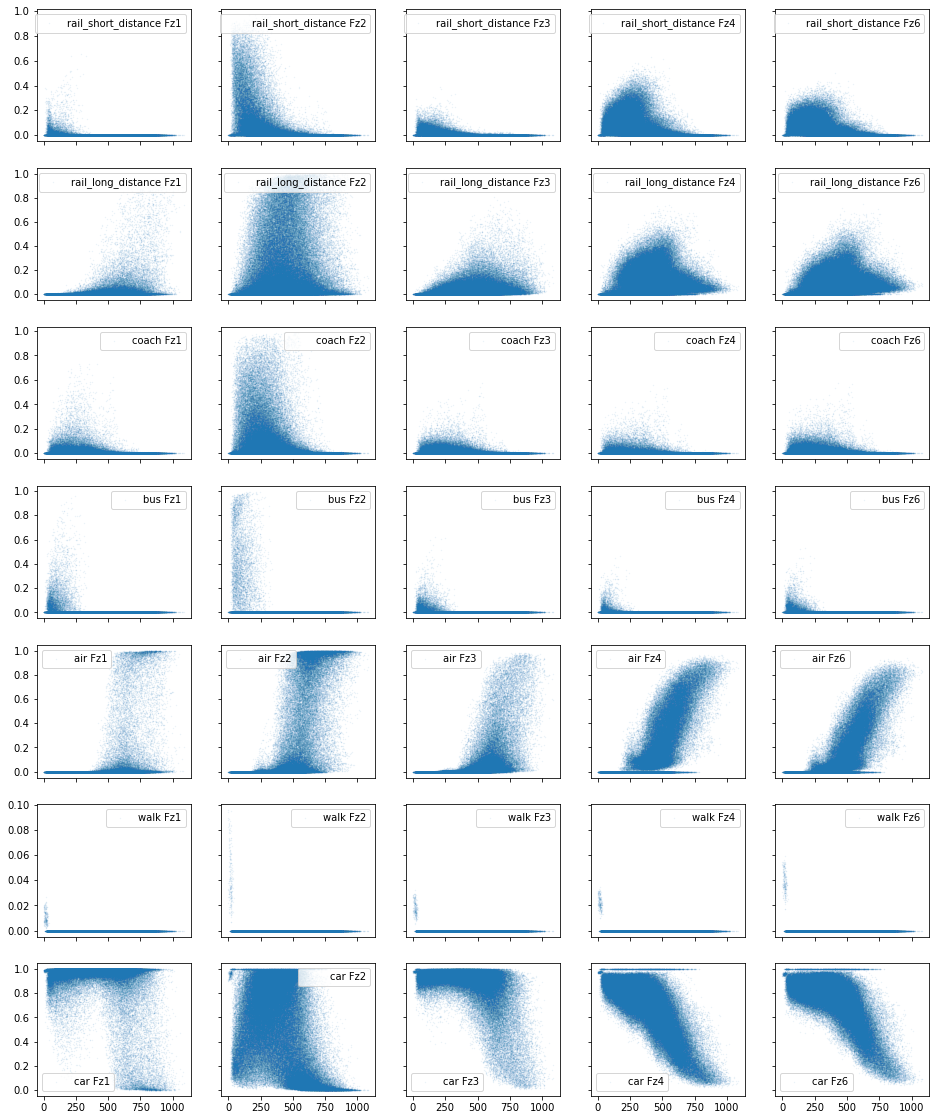

In [47]:
# Distance-dependency of probabilities
import matplotlib.pyplot as plt
merged = sm.probabilities.merge(car.car_los[['origin', 'destination', 'length']],
                                on=['origin', 'destination'], how='inner')
modes = ['rail_short_distance', 'rail_long_distance', 'coach', 'bus', 'air', 'walk', 'car']
fig, ax = plt.subplots(nrows=7, ncols=5, sharex='all', sharey='row', figsize=(16,20))
for i, mode in zip(range(len(modes)), modes):
    for j, seg in zip(range(5), merged['segment'].unique()):
        x = merged.loc[merged['segment']==seg, 'length'] / 1000
        y = merged.loc[merged['segment']==seg, mode]
        ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.1, label=mode+' '+seg)
        #p = np.poly1d(np.polyfit(x, y, deg=3))
        #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
        ax[i,j].legend()

<AxesSubplot:xlabel='length'>

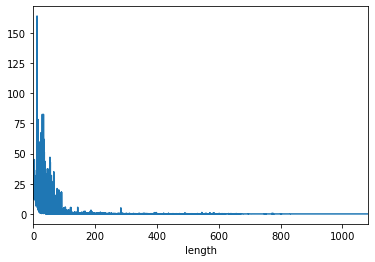

In [28]:
# Plot the trip volumes by distance to get an idea
# about the importance of probabilities on short relations
vp2017 = pd.read_csv('../input_static/vp2017_validation_normalised.csv')
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.set_index(['origin', 'destination'], drop=True).sum(axis=1).reset_index()
vp2017['v'] = vp2017[0] * 1000
merged = vp2017.merge(car.car_los[['origin', 'destination', 'length']],
                      on=['origin', 'destination'], how='inner')
merged['length'] = merged['length'] / 1000
merged.sort_values('length').set_index('length')['v'].plot()

In [29]:
# Which route types are accessible at the high-volume connections?
connections = pd.DataFrame(index=sm.los['route_type'].unique())
for head in [1, 10, 100, 1000, 10000, 100000]:
    connections[str(head)] = sm.los.loc[
        (sm.los['origin'].isin(list(merged.sort_values('v').tail(head)['origin']))) &
        (sm.los['destination'].isin(list(merged.sort_values('v').tail(head)['destination'])))
    ].groupby('route_type')['time'].count()
connections

,1,10,100,1000,10000,100000
coach,NaN,184,11425,240918,308119,308119
rail_short_distance,NaN,120,8592,266916,353861,353861
rail_long_distance,NaN,223,14810,350449,467323,467323
bus,NaN,8,306,7696,9932,9932
air,NaN,63,8462,199783,250134,250134
walk,1.0,6,44,220,228,228
car,1.0,72,4830,115940,154842,154842


<AxesSubplot:>

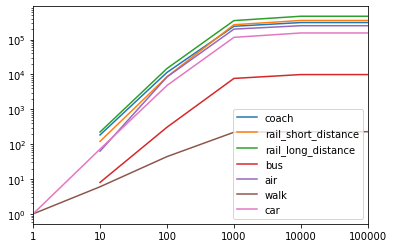

In [32]:
connections.T.plot(logy=True)

In [31]:
merged.sort_values('v').tail(10)

,origin,destination,0,v,length
69741,DE111,DE115,0.067162,67.162336,24.218
71310,DE115,DE111,0.067162,67.162336,24.082
32304,DEA27,DEA23,0.075163,75.163412,31.086
30735,DEA23,DEA27,0.075163,75.163412,31.382
77615,DE128,DE125,0.078357,78.357186,13.809
76438,DE125,DE128,0.078357,78.357186,14.029
69739,DE111,DE113,0.082482,82.482015,32.769
70524,DE113,DE111,0.082482,82.482015,29.011
93363,DE21H,DE212,0.163718,163.717916,12.226
87482,DE212,DE21H,0.163718,163.717916,11.861
